# Support identification: TSOC vs GR

Compressed Sensing (CS) is based on the hypothesis that the input is sparse in some domain, where with sparse we mean a signals whose components are mostly null and only a small minority is different from zero. However, real-world signals are hardly ever sparse due to different reasons as for example the presence of noise in acquisition. Hence, signals cannot be considered sparse but **compressible**, i.e., most components are negligible compared with a small minority which have a significantly higher magnitude.

In the literature, there exist a family of CS decoders [[1]](#TBCAS2020) which reconstruct the input from the mesurement by leveraging the knowledge of the **support** which indicates the position of the non-null coefficients in the sparse representation of the input. 

However, we can define a signal support only when the signal is sparse. In [[2]](#JETCAS2020), we extended the definition of support to compressible signals as the support that, given a CS encoder, maximizes the quality of reconstruction. This definition of support for compressible signals has the disadvantage to depend on how the signal is compressed into measurements, i.e., it depends on the CS encoder.

Recently, we explored the possibility to define a support of a compressible signal independetly from encoding. The idea consists in considering the components with highest magnitude that retain a certain fraction of energy $\eta$. We call this method GR (intials of Gabriele Ravaglia, the student who worked on this first)

This notebook aims to compare the TSOC method (the one proposed in [[2]](#JETCAS2020)) to the recently considered GR method. We expect the former to outperform the latter but depending on the differences there may be cases in which the GR method is preferrable.


In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [3]:
import os
import sys

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neurokit2 as nk

import multiprocessing as mp

from itertools import product

from scipy import linalg
from numpy import random

from tqdm import tqdm


In [4]:
# import of local modules
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset import dataset_dir
from dataset.synthetic_ecg import generate_ecg
from cs.wavelet_basis import wavelet_basis
from cs import CompressedSensing, generate_sensing_matrix
from cs.utils import compute_rsnr

## Dataset

We use a synthetic Electrocardiography (ECG) dataset, the same employed in [[1]](#TBCAS2020) and [[2]](#JETCAS2020). The dataset has been generated with [ECGSYN](https://physionet.org/content/ecgsyn/1.0.0/) (which implements the algorithm reported in [[3]](#McSharry_TBME2003)).

The heart-beat rate is randomly set using an uniform distribution between 60 and 100 beat/minute. We generate chunks of 2s with a 256sample/s sampling frequency, that are split into windows
of n subsequent samples.

In [5]:
N = 10_000              # number of ECG traces
n = 128                 # length of an ECG trace
fs = 256                # sampling rate
heart_rate = (60, 100)  # min and max heart rate
isnr = 25               # signal-to-noise ratio in dB (35)
ecg_seed = 0            # random seed for ECG generation
processes = 24          # number of processes for multiprocessing


def build_data_name(isnr):
    name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
        f'_isnr={isnr}_seed={ecg_seed}'
    return name


In [6]:

data_path = os.path.join(dataset_dir, build_data_name(isnr) + '.pkl')
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        X = pickle.load(f)
else:
    X = generate_ecg(
        length=n, 
        num_traces=N,
        heart_rate=heart_rate, 
        sampling_rate=fs, 
        snr=isnr, 
        random_state=ecg_seed,
        verbose=True,
        processes=processes,
    )
    with open(data_path, 'wb') as f:
        pickle.dump(X, f)

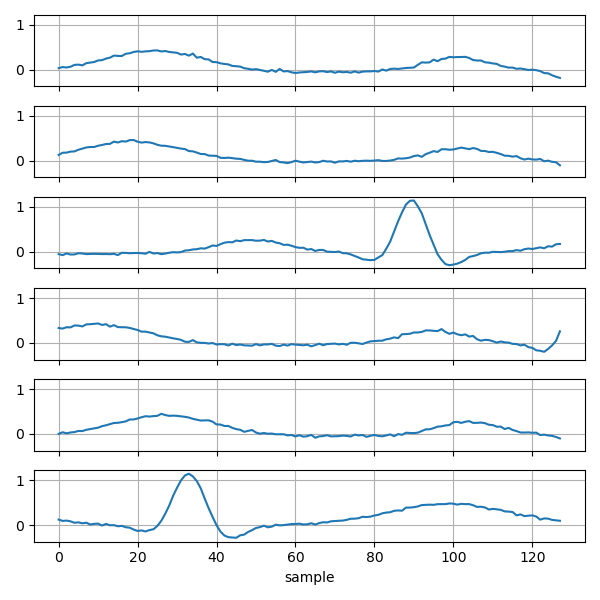

In [7]:
num_plot = 6

fig, axs = plt.subplots(num_plot, 1, figsize=(6, 1.*num_plot), 
                        sharex='all', sharey='all')
for i, (ax, x) in enumerate(zip(axs, X)):
    ax.plot(x)
    ax.grid()
axs[-1].set(xlabel='sample')
fig.tight_layout()

As in [[1]](#TBCAS2020) and [[2]](#JETCAS2020) and firstly proposed in [[4]](#TBCAS2015), we employ the Symmlet-6 family of the orthogonal Wavelet functions as a Sparsity basis.

In [8]:
basis = 'sym6'

D = wavelet_basis(n, basis, level=2)

## GR Algorithm

Identify signal support with GR algortithm which identify the support by considering the smallest subsets of compontest that retains a given energy fraction.

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- support identification method: the amount of energy fraction used to determine the support
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [9]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ---- 
method = 'GR' # support identification algorithm
eta_list = (
    0.9, 
    0.93,    0.95,    0.97,    0.98,    0.985,    0.99, 
    0.993,   0.995,   0.997,   0.998,   0.9985,   0.999, 
    0.9993,  0.9995,  0.9997,  0.9998,  0.99985,  0.9999, 
    0.99993, 0.99995, 0.99997, 0.99998, 0.999985, 0.99999,
)  # energy fractions

# ---- compressed sensing ---- 
m_list = (16, 32, 48, 64)  # number of measurements
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth_list = (False, True)  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr = '96af96a7ddfcb2f6059092c250e18f2a'

#### Supports

In [10]:
def build_supports_name(method, eta):
    return f'supports_method={method}_eta={eta}.pkl'

In [11]:
supports = []
for isnr, eta in product(isnr_list, eta_list):
    supports_dir = os.path.join(dataset_dir, build_data_name(isnr))
    supports_name = build_supports_name(method, eta)
    with open(os.path.join(supports_dir, supports_name), 'rb') as f:
        S = pickle.load(f)
    S = pd.DataFrame(S).rename_axis(index='sample', columns='feature')
    col = pd.MultiIndex.from_tuples([(isnr, eta)], names=('isnr', 'eta'))
    supports.append(pd.DataFrame(data=S.unstack(), columns=col))
supports = pd.concat(supports, axis=1)

In [12]:
hist = supports.groupby('feature').mean()

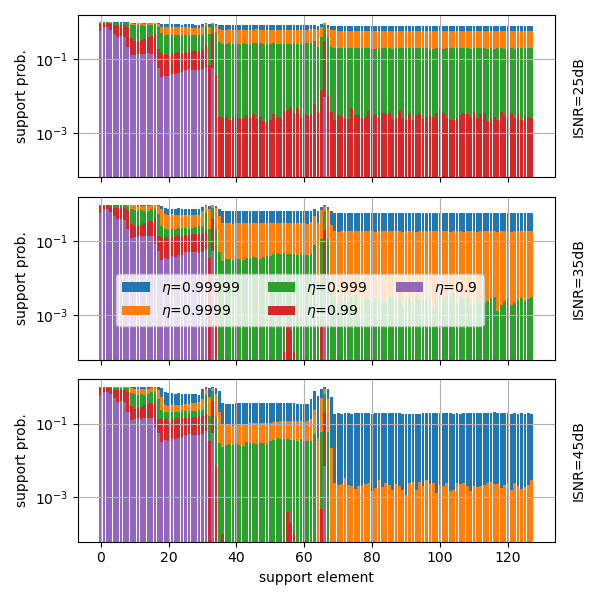

In [13]:
nrows = len(isnr_list)
fig, axs = plt.subplots(nrows, 1, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all')
for ax, isnr in zip(axs, isnr_list):
    _hist = hist.xs(isnr, level='isnr', axis=1)
    for i, eta in enumerate(_hist.columns.unique('eta')[::-6]):
        ax.bar(hist.index, _hist[eta].values, 
               color=f'C{i}', label=f'$\eta$={eta}')
    ax.grid(True)
    ax.set(yscale='log')
    ax.set(ylabel='support prob.')
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
axs[-1].set(xlabel='support element')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=min(3, len(eta_list)))
# fig.suptitle(f'orth={orth}')
fig.tight_layout()


#### Sparsity

In [14]:
sparsity = supports.groupby(level='sample').sum()
sparsity_stat = sparsity.describe().T
sparsity_stat

count     mean       std   min   25%   50%   75%   max
isnr eta                                                               
25   0.900000  10000.0   6.4624  2.022670   1.0   5.0   7.0   8.0  11.0
     0.930000  10000.0   7.4562  2.162764   1.0   6.0   8.0   9.0  12.0
     0.950000  10000.0   8.4347  2.306224   1.0   7.0   9.0  10.0  14.0
     0.970000  10000.0  10.0473  2.564122   2.0   8.0  10.0  12.0  17.0
     0.980000  10000.0  11.4850  2.811115   2.0  10.0  12.0  13.0  23.0
...                ...      ...       ...   ...   ...   ...   ...   ...
45   0.999950  10000.0  34.6341  5.889167  11.0  31.0  34.0  38.0  69.0
     0.999970  10000.0  39.9125  6.599424  14.0  35.0  39.0  43.0  80.0
     0.999980  10000.0  45.2827  7.625037  17.0  40.0  45.0  49.0  87.0
     0.999985  10000.0  49.8085  8.224767  21.0  45.0  49.0  54.0  91.0
     0.999990  10000.0  56.8718  8.572369  24.0  51.0  56.0  62.0  96.0

[75 rows x 8 columns]

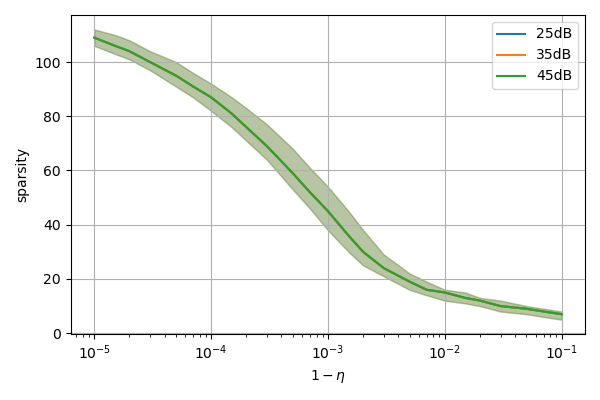

In [15]:
nrows = len(isnr_list)
fig, ax = plt.subplots(figsize=(6, 4))

for i, isnr in enumerate(isnr_list):
    color = f'C{i}'
    _stats = sparsity_stat.xs(25, level='isnr')
    xaxis = 1 - _stats.index
    ax.plot(xaxis, _stats['50%'], label=f'{isnr}dB', color=color)
    ax.fill_between(xaxis, _stats['25%'], _stats['75%'], color=color, alpha=0.2)
ax.set(xscale='log')
ax.set(xlabel='$1-\eta$', ylabel='sparsity')
ax.grid(True)
ax.legend()
fig.tight_layout()

#### Reconstruction

The experiments are conducted through the script `compute_rsnr_GR.py`. Here we load and visulize the results.

In [16]:
rsnr = []
for isnr in isnr_list:
    rsnr_dir = os.path.join(dataset_dir, build_data_name(isnr))
    
    for mode in mode_list:
        
        # load RSNRs
        rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
        rsnr_path = os.path.join(rsnr_dir, rsnr_name)
        if not os.path.exists(rsnr_path):
            continue
        tmp = pd.read_pickle(rsnr_path)

        if mode == 'rakeness':
            # select rakeness configuration indicated above
            tmp = tmp.xs((corr, loc), level=('corr', 'loc'), axis=1)

        # select the only columns indicated above
        tmp = tmp.reindex(columns=eta_list, level='eta')
        tmp = tmp.reindex(columns=m_list, level='m')
        tmp = tmp.reindex(columns=orth_list, level='orth')

        # create new multiindex levels for isnr and mode
        tmp = pd.concat(
            [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
        tmp = pd.concat(
            [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
        
        rsnr.append(tmp)

rsnr = pd.concat(rsnr, axis=1)

In [17]:
# compute statistics
_rsnr = rsnr.stack('seed')  # average over samples and sensing matrices

_cols = ('isnr', 'mode', 'm', 'orth')
rsnr_count = _rsnr.count().unstack(_cols)
rsnr_med = _rsnr.median().unstack(_cols)
rsnr_mean = _rsnr.mean().unstack(_cols)
rsnr_std = _rsnr.std().unstack(_cols)
rsnr_min = _rsnr.min().unstack(_cols)
rsnr_max = _rsnr.max().unstack(_cols)
rsnr_q25 = _rsnr.quantile(.25).unstack(_cols)
rsnr_q75 = _rsnr.quantile(.75).unstack(_cols)

# find eta provinding highest median RSNR for each configuration
eta_best = rsnr_med.idxmax()

In [18]:
df = pd.DataFrame(
    index=rsnr_med.columns,
    columns=('eta', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max')
)
for row, eta in rsnr_med.idxmax().items():
    df.loc[row] = (
        eta, 
        rsnr_count.loc[eta, row],
        rsnr_mean.loc[eta, row],
        rsnr_std.loc[eta, row],
        rsnr_min.loc[eta, row],
        rsnr_q25.loc[eta, row],
        rsnr_med.loc[eta, row],
        rsnr_q75.loc[eta, row],
        rsnr_max.loc[eta, row],
    )

df

eta   count       mean       std        min  \
isnr mode     m  orth                                                      
25   rakeness 16 False     0.985  200000  11.710903   5.96683 -90.409826   
                 True      0.985  200000  12.118584  6.037663 -90.409826   
              32 False     0.997  200000  18.993919  5.146917 -48.543806   
                 True      0.997  200000  19.381347  5.305032 -48.543806   
              48 False     0.998  200000  22.384004  4.308747 -78.569294   
                 True      0.998  200000  22.861862  4.422973 -78.569294   
              64 False     0.999  200000  24.275371  4.459411 -55.156853   
                 True      0.999  200000    24.8989  4.621546 -55.156853   
     standard 16 False     0.985  200000  11.248961  5.466944 -78.071397   
                 True       0.98  200000  11.523147  4.776037 -58.033933   
              32 False     0.995  200000  18.743082  3.515111 -56.128595   
                 True      0.995  200000  19.012832  3.554451 -56.128595   
              48 False     0.998  200000  21.123421  4.909984 -80.084533   
                 True      0.998  200000  21.540131   5.03844 -80.084533   
              64 False     0.999  200000   23.24231  5.010783 -42.431842   
                 True      0.999  200000  23.856947   5.21635 -42.431842   
35   rakeness 16 False      0.99  200000  12.604661  6.505711 -91.119066   
                 True       0.99  200000  13.028802  6.631517 -91.119066   
              32 False    0.9995  200000  25.328437  6.076994  -61.21207   
                 True     0.9993  200000  26.501591  4.680387 -49.007616   
              48 False    0.9997  200000  30.874208  4.140341  -39.96224   
                 True     0.9997  200000  31.392835  4.241755  -39.96224   
              64 False   0.99985  200000  33.479383  4.214747  -31.95271   
                 True    0.99985  200000  34.095393  4.332763  -31.95271   
     standard 16 False      0.99  200000  12.471965  6.140609 -75.791762   
                 True       0.99  200000  12.551411  6.171114 -75.791762   
              32 False    0.9993  200000  24.646594  5.162336 -57.576279   
                 True     0.9993  200000  24.871803  5.221846 -57.576279   
              48 False    0.9997  200000  29.496936  5.037524 -34.962729   
                 True     0.9997  200000  29.939093  5.136991 -34.962729   
              64 False   0.99985  200000  32.311459  5.058824 -39.829974   
                 True    0.99985  200000  32.984636  5.217032 -39.829974   
45   rakeness 16 False      0.99  200000  12.678832  6.487365 -95.482934   
                 True       0.99  200000  13.123255  6.621895 -95.482934   
              32 False   0.99985  200000  28.486101  7.912692 -38.383602   
                 True    0.99985  200000  28.804573  8.083484 -38.383602   
              48 False   0.99997  200000  37.394677  6.960756 -31.165102   
                 True    0.99997  200000  37.741975  7.085596 -31.165102   
              64 False  0.999985  200000  41.517584  6.163883 -76.702527   
                 True   0.999985  200000  42.060451  6.311951 -76.702527   
     standard 16 False      0.99  200000  12.653575  6.109948 -76.103467   
                 True       0.99  200000   12.73618  6.139727 -76.103467   
              32 False   0.99985  200000  26.524135  9.092851 -65.650735   
                 True    0.99985  200000  26.679182  9.184373 -65.650735   
              48 False   0.99997  200000  35.708511  8.065263 -40.394741   
                 True    0.99995  200000   37.47871  4.686797 -35.961292   
              64 False  0.999985  200000   40.15106  7.376957 -21.590997   
                 True    0.99998  200000    41.5371  5.662057 -22.262872   

                              25%        50%        75%        max  
isnr mode     m  orth                                               
25   rakeness 16 False   9.014076  13.015717  15.847099   23.46837  
                 True

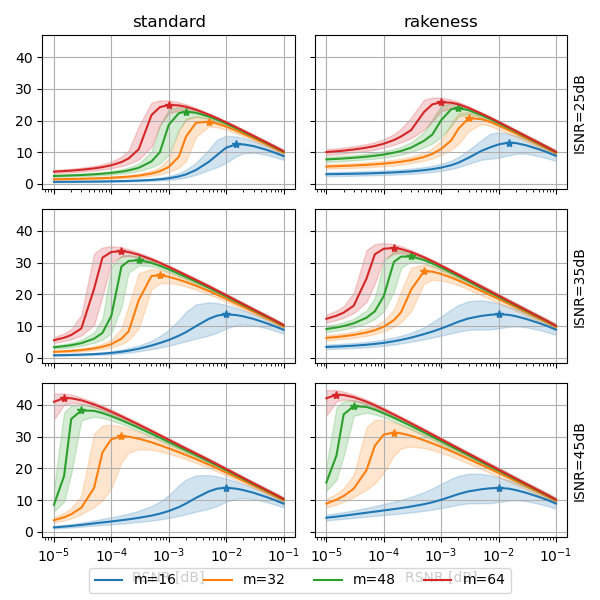

In [19]:
orth = False

ncols = len(mode_list)
nrows = len(isnr_list)

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
index = 1 - rsnr_med.index
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        _rsnr_med = rsnr_med.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(_rsnr_med.columns):
            ax.plot(index, rsnr_med[isnr, mode, m, orth], label=f'm={m}')
            ax.fill_between(
                index, 
                rsnr_q25[isnr, mode, m, orth], 
                rsnr_q75[isnr, mode, m, orth], 
                color=f'C{i}', alpha=0.2)
            ax.plot(
                [1 - eta_best[isnr, mode, m, orth]], 
                [rsnr_med.max()[isnr, mode, m, orth]], 
                marker='*', color=f'C{i}')
        ax.set(xscale='log')
        ax.grid()

for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


- the higher the number of mesurements `m` (i.e., lower the compression ratio) the higher the energy fraction $\eta$ that gives the best performance. This is intuitive as a higher compression leaves less room for components.

- As the noise energy increases (lower ISNR), the lower the the energy fraction $\eta$ that gives the best performance. This behavior is expected as with a higher noise swallows more components so that a fewer number contributes for the signal reconstruction.


## TSOC Algorithm

Identify signal support with TSOC algortithm which identify the support as the one maximizing the quality of reconstruction.

### working principle

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [21]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(100)

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list)),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:
        # find and sort sparse representation of x
        xi = D.T @ x
        argsort_xi = np.argsort(np.abs(xi))[::-1]
        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        s = np.zeros(cs.n, dtype=bool)
        for i in range(m + 10):
            s[argsort_xi[i]] = True  # update support
            x_hat = cs.decode(y, s=s)  # reconstruct input
            rsnr.loc[i + 1, (m, seed)] = compute_rsnr(x, x_hat)

100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


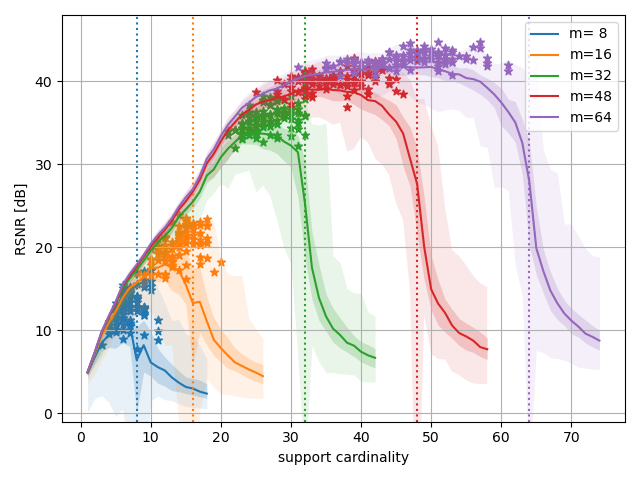

In [25]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]', ylim=(-1, 48))
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [20]:
# Experiment parameters

# ---- data ----
isnr_list = (25, 35, 45)  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth_list = (False, True)  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr = '96af96a7ddfcb2f6059092c250e18f2a'

#### Supports

Supports computed by mean script `compute_supports.py`.

In [21]:
def build_supports_name(method, mode, m, orth):
    name = f'supports_method={method}_mode={mode}_m={m}'
    if mode == 'rakeness':
        name += f'_corr={corr}_loc={loc}'
    name += f'_orth={orth}'
    return name

In [22]:
supports = []
col_names = ('isnr', 'mode', 'm', 'orth', 'seed')
args_list = product(isnr_list, mode_list, m_list, orth_list)
for isnr, mode, m, orth in args_list:
    supports_dir = os.path.join(dataset_dir, build_data_name(isnr))
    supports_name = build_supports_name(method, mode, m, orth)
    for name in os.listdir(supports_dir):
        if not name.startswith(supports_name):
            continue
        seed = int(name.replace('.pkl', '').split('_')[-1].split('=')[1])
        with open(os.path.join(supports_dir, name), 'rb') as f:
            S = pickle.load(f)
        S = pd.DataFrame(S).rename_axis(index='sample', columns='feature')
        col = pd.MultiIndex.from_tuples(
            [(isnr, mode, m, orth, seed)], names=col_names)
        supports.append(pd.DataFrame(data=S.unstack(), columns=col))
supports = pd.concat(supports, axis=1)

In [23]:
hist = pd.DataFrame(columns=supports.columns.droplevel('seed').unique())
for col in hist.columns:
    hist[col] = supports\
        .xs(col, level=hist.columns.names, axis=1,)\
        .unstack('sample')\
        .mean(axis=1)

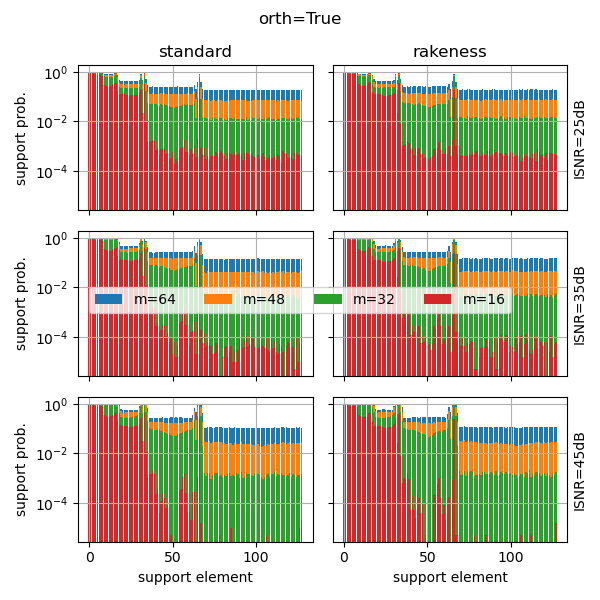

In [25]:
orth = True

ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        _hist = hist.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(_hist.columns.unique('m')[::-1]):
            color = f'C{i}'
            ax.bar(hist.index, _hist[m].values, color=color, label=f'm={m}')
        ax.grid(True)
        ax.set(yscale='log')
    _axs[0].set(ylabel='support prob.')

for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='support element')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=max(4, len(m_list)))
fig.suptitle(f'orth={orth}')
fig.tight_layout()


#### Sparsity

In [26]:
sparsity = supports.groupby(level='sample').sum().stack('seed')
sparsity_stat = sparsity.describe().T
sparsity_stat

count       mean       std   min   25%   50%   75%  \
isnr mode     m  orth                                                           
25   rakeness 16 False  200000.0  12.667375  2.212460   2.0  11.0  13.0  14.0   
                 True   200000.0  12.586130  2.157678   3.0  11.0  13.0  14.0   
              32 False  200000.0  22.691350  4.303208   5.0  20.0  23.0  26.0   
                 True   200000.0  22.573605  4.074952   5.0  20.0  23.0  25.0   
              48 False  200000.0  31.986980  6.194888   7.0  28.0  32.0  36.0   
                 True   200000.0  32.170100  5.625918  10.0  28.0  32.0  36.0   
              64 False  200000.0  45.695980  7.875812  12.0  40.0  46.0  52.0   
                 True   200000.0  45.671385  6.933185  16.0  41.0  46.0  51.0   
     standard 16 False  200000.0  12.367765  2.274460   2.0  11.0  13.0  14.0   
                 True   200000.0  12.347640  2.264542   2.0  11.0  13.0  14.0   
              32 False  200000.0  21.898885  4.427785   4.0  19.0  22.0  25.0   
                 True   200000.0  21.839250  4.296484   4.0  19.0  22.0  25.0   
              48 False  200000.0  31.677935  6.361979   8.0  27.0  32.0  36.0   
                 True   200000.0  31.499415  5.966098   9.0  27.0  31.0  36.0   
              64 False  200000.0  45.561580  7.976351  13.0  40.0  46.0  52.0   
                 True   200000.0  44.989060  7.349628  15.0  40.0  45.0  50.0   
35   rakeness 16 False  200000.0  13.188155  2.046493   2.0  12.0  13.0  15.0   
                 True   200000.0  13.102480  2.000944   3.0  12.0  13.0  15.0   
              32 False  200000.0  25.956695  3.717359  10.0  24.0  27.0  29.0   
                 True   200000.0  25.796110  3.645033  11.0  24.0  26.0  28.0   
              48 False  200000.0  35.165615  5.492412  12.0  32.0  35.0  39.0   
                 True   200000.0  35.056845  5.157375  12.0  32.0  35.0  39.0   
              64 False  200000.0  47.389595  7.131393  18.0  42.0  48.0  53.0   
                 True   200000.0  47.145815  6.509172  20.0  43.0  47.0  52.0   
     standard 16 False  200000.0  13.150550  1.962041   3.0  12.0  13.0  15.0   
                 True   200000.0  13.125420  1.959390   2.0  12.0  13.0  15.0   
              32 False  200000.0  25.393860  3.888249   8.0  23.0  26.0  28.0   
                 True   200000.0  25.309230  3.851331   8.0  23.0  26.0  28.0   
              48 False  200000.0  34.813855  5.664306  10.0  31.0  35.0  39.0   
                 True   200000.0  34.527375  5.436799  10.0  31.0  35.0  38.0   
              64 False  200000.0  47.149945  7.274121  16.0  42.0  47.0  53.0   
                 True   200000.0  46.464910  6.811878  17.0  42.0  47.0  51.0   
45   rakeness 16 False  200000.0  13.311990  2.033230   2.0  12.0  14.0  15.0   
                 True   200000.0  13.229985  1.987942   3.0  12.0  13.0  15.0   
              32 False  200000.0  27.852695  2.889069  13.0  26.0  28.0  30.0   
                 True   200000.0  27.706955  2.897901  13.0  26.0  28.0  30.0   
              48 False  200000.0  38.490910  5.016515  15.0  35.0  39.0  42.0   
                 True   200000.0  38.297190  4.887129  15.0  35.0  39.0  42.0   
              64 False  200000.0  49.564640  6.407366  19.0  45.0  50.0  54.0   
                 True   200000.0  49.165190  6.008994  22.0  45.0  49.0  53.0   
     standard 16 False  200000.0  13.392115  1.887940   3.0  12.0  14.0  15.0   
                 True   200000.0  13.368655  1.887495   2.0  12.0  14.0  15.0   
              32 False  200000.0  27.515865  3.059749  12.0  26.0  28.0  30.0   
                 True   200000.0  27.444815  3.060428  11.0  26.0  28.0  30.0   
              48 False  200000.0  38.207820  5.198850  14.0  35.0  39.0  42.0   
                 True   200000.0  37.963870  5.123336  14.0  35.0  38.0  42.0   
              64 False  200000.0  49.310705  6.608161  17.0  45.0  50.0  54.0   
                 True   200000.0  48.617585  6.344588  21.

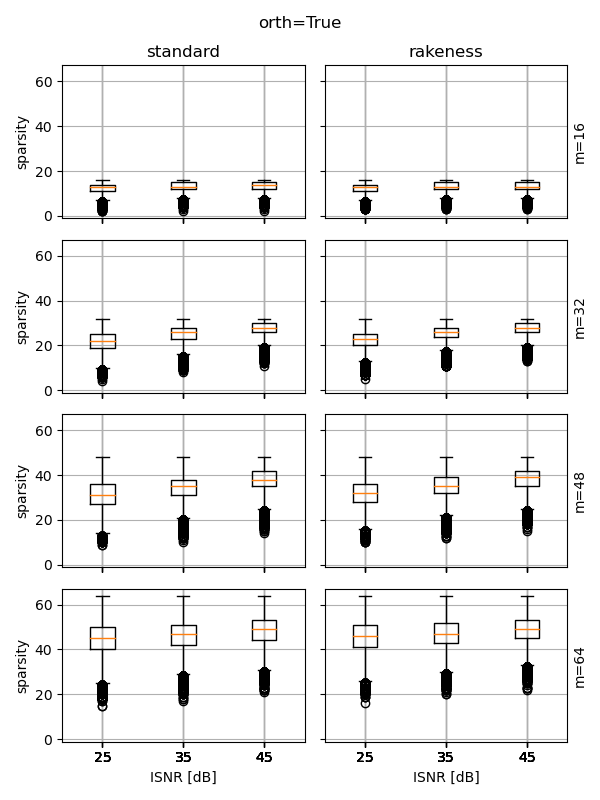

In [27]:
orth = True

ncols, nrows = len(mode_list), len(m_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
for _axs, m in zip(axs, m_list):
    for ax, mode in zip(_axs, mode_list):
        _sparsity = sparsity.xs(
            (mode, m, orth), level=('mode', 'm', 'orth'), axis=1)
        ax.boxplot(_sparsity.values, labels=_sparsity.columns)
        ax.grid(True)
        # ax.set(yscale='log')
    _axs[0].set(ylabel='sparsity')

for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, m in zip(axs[:, -1], m_list): 
    ax.text(1.05, 0.5, f'm={m}', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='ISNR [dB]')

# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center', ncol=max(4, len(m_list)))
fig.suptitle(f'orth={orth}')
fig.tight_layout()


#### Reconstruction

The experiments are conducted through the script `compute_rsnr.py`. Here we load and visulize the results.

In [28]:
rsnr = []
for isnr, mode in product(isnr_list, mode_list):
    rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
    rsnr_path = os.path.join(dataset_dir, build_data_name(isnr), rsnr_name)
    if not os.path.exists(rsnr_path):
        continue
    tmp = pd.read_pickle(rsnr_path)
    if mode == 'rakeness':
        tmp = tmp.xs((corr, loc), level=('corr', 'loc'), axis=1)
    # tmp = tmp.xs(orth, level='orth', axis=1)
    tmp = tmp.reindex(columns=m_list, level='m')
    tmp = pd.concat(
        [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
    tmp = pd.concat(
        [tmp], keys=[isnr], names=['isnr'] + tmp.columns.names, axis=1)
    rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [29]:
_rsnr = rsnr.stack('seed')
rsnr_stat = _rsnr.describe().T
rsnr_stat

count       mean       std        min        25%  \
isnr mode     m  orth                                                         
25   rakeness 16 False  200000.0  15.211651  3.655637   2.506527  12.593084   
                 True   200000.0  15.532160  3.521277   2.747394  13.006653   
              32 False  200000.0  22.460777  2.208934  12.931341  21.134886   
                 True   200000.0  22.738133  2.167610  13.522208  21.439062   
              48 False  200000.0  24.727456  2.304314  14.182205  23.281097   
                 True   200000.0  25.120159  2.267766  14.999445  23.704921   
              64 False  200000.0  26.576146  2.431488  16.204817  25.030518   
                 True   200000.0  27.176651  2.373604  16.603484  25.667626   
     standard 16 False  200000.0  14.390440  3.116672   1.507402  12.198628   
                 True   200000.0  14.473124  3.108196   1.151488  12.290687   
              32 False  200000.0  21.079785  2.155546  11.314047  19.760601   
                 True   200000.0  21.300053  2.138189  11.371349  19.999397   
              48 False  200000.0  23.721390  2.221207  13.749707  22.359548   
                 True   200000.0  24.118053  2.204825  13.817840  22.769407   
              64 False  200000.0  25.838298  2.341103  15.115125  24.387206   
                 True   200000.0  26.441877  2.318263  16.060630  25.000247   
35   rakeness 16 False  200000.0  16.873753  5.295525   2.118945  13.027351   
                 True   200000.0  17.225964  5.175244   2.096030  13.461773   
              32 False  200000.0  29.158253  2.809778  16.722609  27.275584   
                 True   200000.0  29.418328  2.745766  17.585966  27.588458   
              48 False  200000.0  33.354865  2.207524  24.407526  32.022068   
                 True   200000.0  33.703125  2.175650  24.701974  32.387708   
              64 False  200000.0  35.655161  2.301280  25.878369  34.277989   
                 True   200000.0  36.191289  2.262310  26.546016  34.838059   
     standard 16 False  200000.0  16.381031  4.634587   2.072349  13.036457   
                 True   200000.0  16.450548  4.627120   1.661407  13.105757   
              32 False  200000.0  27.646837  2.729124  16.468998  25.831698   
                 True   200000.0  27.835313  2.717136  16.739762  26.023146   
              48 False  200000.0  32.134989  2.203487  22.691572  30.795511   
                 True   200000.0  32.512240  2.180823  23.280532  31.190975   
              64 False  200000.0  34.754292  2.265870  24.246017  33.396983   
                 True   200000.0  35.350240  2.236445  25.178979  34.017435   
45   rakeness 16 False  200000.0  17.380601  6.173598   2.113217  13.066201   
                 True   200000.0  17.742383  6.065863   1.823345  13.505268   
              32 False  200000.0  33.470395  4.698108  17.141697  29.948076   
                 True   200000.0  33.713375  4.638579  17.317858  30.233177   
              48 False  200000.0  41.099067  2.522590  29.937160  39.545560   
                 True   200000.0  41.413775  2.507116  30.610102  39.872621   
              64 False  200000.0  44.421553  2.175069  34.418747  43.111017   
                 True   200000.0  44.926554  2.145222  34.974757  43.639043   
     standard 16 False  200000.0  17.040033  5.619740   2.109605  13.130241   
                 True   200000.0  17.107159  5.609850   1.795041  13.194630   
              32 False  200000.0  31.997183  4.507809  17.342834  28.692192   
                 True   200000.0  32.158176  4.504413  17.193064  28.839496   
              48 False  200000.0  39.787785  2.571343  28.669670  38.185195   
                 True   200000.0  40.116917  2.576714  28.493613  38.509297   
              64 False  200000.0  43.434312  2.178615  33.221598  42.111128   
                 True   200000.0  44.003295  2.152085  34.129062  42.704692   

                              50%        75%        max  
isnr mode     m  o

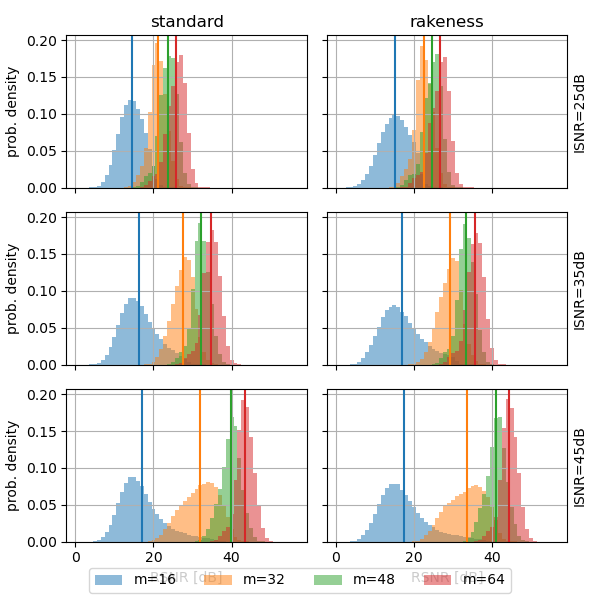

In [30]:
orth = False

ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.min(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.max(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        __rsnr = _rsnr.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(__rsnr.columns.unique('m')):
            color = f'C{i}'
            ax.hist(__rsnr[m], bins=ebins, density=True, 
                    alpha=0.5, label=f'm={m}', color=color)
            ax.axvline(__rsnr[m].mean(), color=color)
            # ax.axvline(__rsnr[m].median(), color=color)
        ax.grid(True)
    _axs[0].set(ylabel='prob. density')


for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


## TSOC2 Algorithm

### working principle


**TOFIX**

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [21]:
i_sample = 0  # index of the ECG sample
m_list = (8, 16, 32, 48, 64)
seed_list = np.arange(20)
delta_m = 10

# load ecg data
with open(data_path, 'rb') as f:
    X = pickle.load(f)
x = X[i_sample]

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list) + delta_m),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        _m = min(cs.n, cs.m + delta_m)
        s1 = np.zeros(cs.n, dtype=bool) 
        for i in range(_m):
            rsnr2 = -np.inf * np.ones(cs.n, dtype=float)
            for j in np.where(~s1)[0]:  
                s2 = s1.copy()
                s2[j] = True
                x_hat = cs.decode_with_support(y, s2)
                rsnr2[j] = compute_rsnr(x, x_hat)
            s_idx = np.argmax(rsnr2)
            s1[s_idx] = True
            rsnr.loc[i + 1, (m, seed)] = rsnr2[s_idx]
            # print(rsnr.loc[i + 1, (m, seed)])

  0%|          | 0/20 [00:03<?, ?it/s]


KeyboardInterrupt: 


KeyboardInterrupt



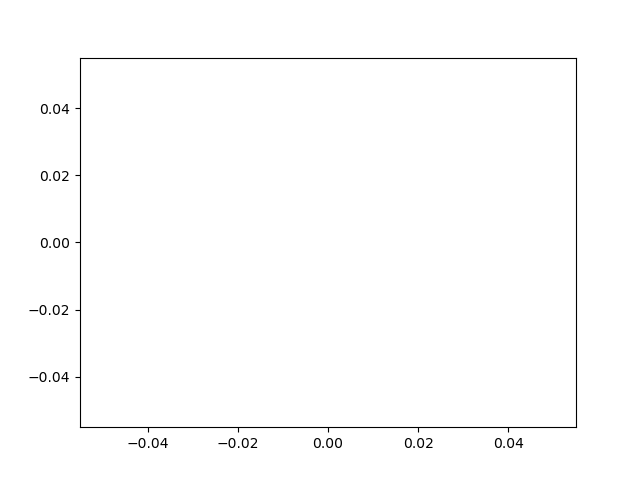

In [22]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]')
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [11]:
# Experiment parameters

# ---- data ----
isnr_list = (35, )  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC2'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
mode_list = ('standard', 'rakeness')  # CS mode: standard, rakeness
orth_list = (True, )  # whether orthogonalize sensing matrix or not

# ---- rakeness ----
loc = .25
corr = '96af96a7ddfcb2f6059092c250e18f2a'

#### Supports

In [7]:
def build_supports_name(method, mode, m, orth):
    name = f'supports_method={method}_mode={mode}_m={m}'
    if mode == 'rakeness':
        name += f'_corr={corr}_loc={loc}'
    name += f'_orth={orth}'
    return name

In [10]:
supports = []
col_names = ('isnr', 'mode', 'm', 'orth', 'seed')
args_list = product(isnr_list, mode_list, m_list, orth_list)
for isnr, mode, m, orth in args_list:
    supports_dir = os.path.join(dataset_dir, build_data_name(isnr))
    supports_name = build_supports_name(method, mode, m, orth)
    for name in os.listdir(supports_dir):
        if not name.startswith(supports_name):
            continue
        seed = int(name.replace('.pkl', '').split('_')[-1].split('=')[1])
        with open(os.path.join(supports_dir, name), 'rb') as f:
            S = pickle.load(f)
        S = pd.DataFrame(S).rename_axis(index='sample', columns='feature')
        col = pd.MultiIndex.from_tuples(
            [(isnr, mode, m, orth, seed)], names=col_names)
        supports.append(pd.DataFrame(data=S.unstack(), columns=col))
supports = pd.concat(supports, axis=1)

In [9]:
hist = pd.DataFrame(columns=supports.columns.droplevel('seed').unique())
for col in hist.columns:
    hist[col] = supports\
        .xs(col, level=hist.columns.names, axis=1,)\
        .unstack('sample')\
        .mean(axis=1)

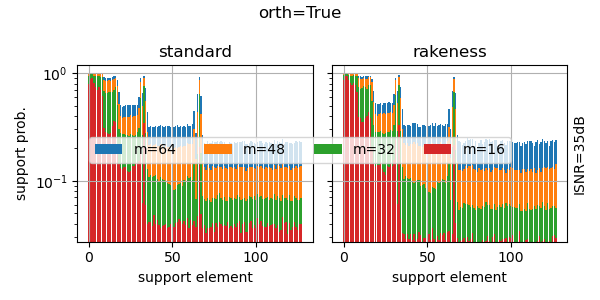

In [35]:
orth = True

ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 1 + 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        _hist = hist.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(_hist.columns.unique('m')[::-1]):
            color = f'C{i}'
            ax.bar(hist.index, _hist[m].values, color=color, label=f'm={m}')
        ax.grid(True)
        ax.set(yscale='log')
    _axs[0].set(ylabel='support prob.')

for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='support element')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=max(4, len(m_list)))
fig.suptitle(f'orth={orth}')
fig.tight_layout()


#### Sparsity

In [36]:
sparsity = supports.groupby(level='sample').sum().stack('seed')
sparsity_stat = sparsity.describe().T
sparsity_stat

count       mean       std   min   25%   50%   75%  \
isnr mode     m  orth                                                          
35   rakeness 16 True  200000.0  16.041675  3.177537   4.0  14.0  15.0  20.0   
              32 True  190000.0  28.395226  2.644489  13.0  27.0  29.0  30.0   
              48 True   90000.0  41.694511  2.669998  27.0  40.0  42.0  44.0   
              64 True   40000.0  54.070050  3.069125  41.0  52.0  54.0  56.0   
     standard 16 True  200000.0  15.760685  2.767882   4.0  14.0  15.0  19.0   
              32 True  200000.0  28.172445  2.434834  12.0  27.0  29.0  30.0   
              48 True  200000.0  40.846530  3.008744  22.0  39.0  41.0  43.0   
              64 True  200000.0  52.926460  3.339548  31.0  51.0  53.0  55.0   

                        max  
isnr mode     m  orth        
35   rakeness 16 True  20.0  
              32 True  36.0  
              48 True  52.0  
              64 True  63.0  
     standard 16 True  20.0  
              32 True  36.0  
              48 True  52.0  
              64 True  67.0

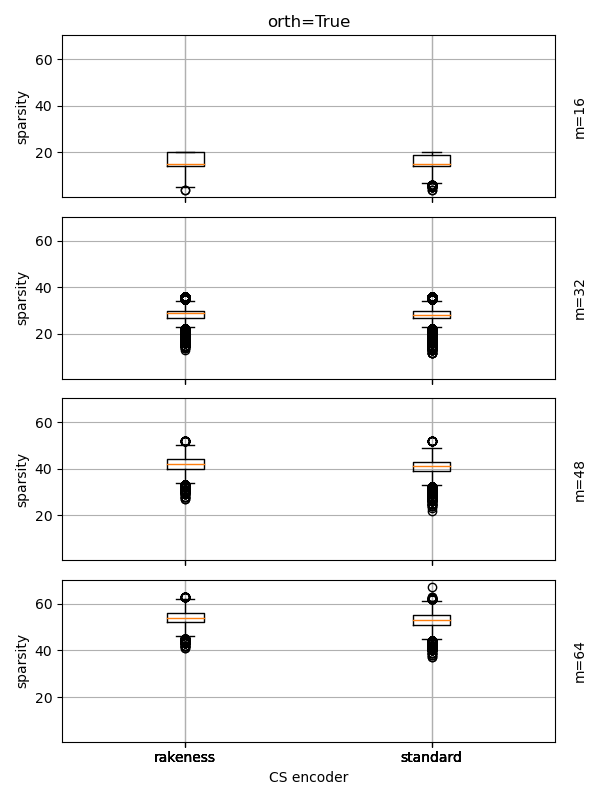

In [37]:
isnr = 35

ncols, nrows = len(orth_list), len(m_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
for _axs, m in zip(axs, m_list):
    for ax, orth in zip(_axs, orth_list):
        _sparsity = sparsity.xs(
            (isnr, m, orth), level=('isnr', 'm', 'orth'), axis=1)
        ax.boxplot(_sparsity.dropna().values, labels=_sparsity.columns)
        ax.grid(True)
        # ax.set(yscale='log')
    _axs[0].set(ylabel='sparsity')

for ax, orth in zip(axs[0], orth_list): ax.set(title=f'orth={orth}')
for ax, m in zip(axs[:, -1], m_list): 
    ax.text(1.05, 0.5, f'm={m}', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='CS encoder')

# fig.suptitle(f'orth={orth}')
fig.tight_layout()


#### Reconstruction

The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [12]:
rsnr = []
for isnr in isnr_list:
    data_name = f'ecg_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={ecg_seed}'
    for mode in mode_list:
        rsnr_name = f'rsnr_method={method}_mode={mode}.pkl'
        rsnr_path = os.path.join(dataset_dir, data_name, rsnr_name)
        if not os.path.exists(rsnr_path):
            continue
        tmp = pd.read_pickle(rsnr_path)
        if mode == 'rakeness':
            tmp = tmp.xs((corr, loc), level=('corr', 'loc'), axis=1)
        tmp = tmp.reindex(columns=m_list, level='m')
        tmp = pd.concat(
            [tmp], keys=[mode], names=['mode'] + tmp.columns.names, axis=1)
        tmp = pd.concat(
            [tmp], keys=[isnr], names=['isnr'] + tmp.columns.names, axis=1)
        rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [13]:
_rsnr = rsnr.stack('seed')
rsnr_stat = _rsnr.describe().T
rsnr_stat

count       mean       std        min        25%  \
isnr mode     m  orth                                                        
35   rakeness 16 True  200000.0  16.664083  5.669384   0.822348  12.522718   
              32 True  200000.0  28.229706  4.330617   6.626609  25.795811   
              48 True  180000.0  34.346605  2.457242  17.790211  32.965186   
              64 True  150000.0  37.095797  2.287861  27.373693  35.676012   
     standard 16 True  200000.0  15.470801  5.403692   0.767416  11.635750   
              32 True  200000.0  26.764179  4.332816   5.926827  24.295383   
              48 True  200000.0  33.012446  2.765945  13.814930  31.512072   
              64 True  199998.0  36.256430  2.329886  24.892851  34.823836   

                             50%        75%        max  
isnr mode     m  orth                                   
35   rakeness 16 True  16.087473  20.265650  38.681477  
              32 True  28.984996  31.472812  44.498470  
              48 True  34.423009  36.025045  47.317864  
              64 True  37.240799  38.719815  49.407449  
     standard 16 True  14.983202  18.794740  37.212351  
              32 True  27.435815  29.985084  43.721287  
              48 True  33.229439  34.842963  46.594388  
              64 True  36.376377  37.907650  48.908491

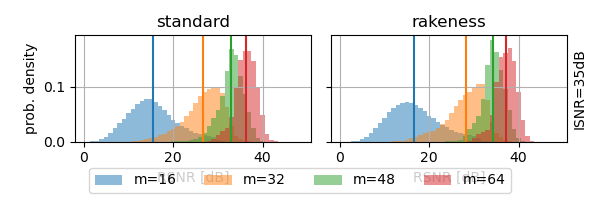

In [173]:
orth = True

ncols, nrows = len(mode_list), len(isnr_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 2*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.nanmin(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.nanmax(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for _axs, isnr in zip(axs, isnr_list):
    for ax, mode in zip(_axs, mode_list):
        __rsnr = _rsnr.xs(
            (isnr, mode, orth), level=('isnr', 'mode', 'orth'), axis=1)
        for i, m in enumerate(__rsnr.columns.unique('m')):
            color = f'C{i}'
            ax.hist(__rsnr[m], bins=ebins, density=True, 
                    alpha=0.5, label=f'm={m}', color=color)
            ax.axvline(__rsnr[m].mean(), color=color)
            # ax.axvline(__rsnr[m].median(), color=color)
        ax.grid(True)
    _axs[0].set(ylabel='prob. density')


for ax, mode in zip(axs[0], mode_list): ax.set(title=mode)
for ax, isnr in zip(axs[:, -1], isnr_list): 
    ax.text(1.05, 0.5, f'ISNR={isnr}dB', rotation='vertical', 
            va='center', ha='center', transform=ax.transAxes)
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=max(4, len(m_list)))
fig.tight_layout()


## References


1. <a name="TBCAS2020"></a> M. Mangia, L. Prono, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracles for Short-Window Optimized Compressed Sensing of Biosignals," in IEEE Transactions on Biomedical Circuits and Systems, vol. 14, no. 3, pp. 545-557, June 2020, doi: [10.1109/TBCAS.2020.2982824](www.doi.org/10.1109/TBCAS.2020.2982824)
2. <a name="JETCAS2020"></a> L. Prono, M. Mangia, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracle With Support Identification in the Compressed Domain," in IEEE Journal on Emerging and Selected Topics in Circuits and Systems, vol. 10, no. 4, pp. 458-468, Dec. 2020, doi: [10.1109/JETCAS.2020.3039731](www.doi.org/10.1109/JETCAS.2020.3039731)
3. <a name="McSharry_TBME2003"></a> P. E. McSharry, G. D. Clifford, L. Tarassenko and L. A. Smith, "A dynamical model for generating synthetic electrocardiogram signals," in IEEE Transactions on Biomedical Engineering, vol. 50, no. 3, pp. 289-294, March 2003, doi: [10.1109/TBME.2003.808805](www.doi.org/10.1109/TBME.2003.808805)
4. <a name="TBCAS2015"></a> F. Pareschi, P. Albertini, G. Frattini, M. Mangia, R. Rovatti and G. Setti, "Hardware-Algorithms Co-Design and Implementation of an Analog-to-Information Converter for Biosignals Based on Compressed Sensing," in IEEE Transactions on Biomedical Circuits and Systems, vol. 10, no. 1, pp. 149-162, Feb. 2016, doi: [10.1109/TBCAS.2015.2444276](www.doi.org/10.1109/TBCAS.2015.2444276)